# Jupiter Notebook for Scenario 07
Requieres: [CategoryEncoders](http://contrib.scikit-learn.org/category_encoders/), [imbalanced-learn](https://imbalanced-learn.org/stable/), [XGBoost](https://pypi.org/project/xgboost/), and [dill](https://pypi.org/project/dill/)<br>
`pip install category_encoders`<br>
`pip install imbalanced-learn`<br>
`pip install xgboost`<br>
`pip install dill`

In [1]:
#import libraries
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from time import perf_counter

In [2]:
#To identify class 0 and 1, respectively
target_names = ['class 0', 'class 1']

In [3]:
#load dataset
df=pd.read_csv('esc-07-Mixed-traffic.csv')

In [4]:
#No trunkated 
pd.set_option('display.max_columns', None)

In [5]:
#Dataset dimensions, number of sessions and features
df.shape

(338434, 52)

In [6]:
#counting classes
collections.Counter(df.label.values)

Counter({0: 323232, 1: 15202})

In [7]:
#check the number of null values
print(df.isnull().sum())
print(df.isnull().values.sum())

proto                 0
ts                    0
srcIP                 0
srcPrt                0
dstIP                 0
dstPrt                0
flowduration          0
total_fpackets        0
total_bpackets        0
total_fpktl           0
total_bpktl           0
min_fpktl             0
min_bpktl             0
max_fpktl             0
max_bpktl             0
mean_fpktl            0
mean_bpktl            0
std_fpktl             0
std_bpktl             0
total_fipt            0
total_bipt            0
min_fipt              0
min_bipt              0
max_fipt              0
max_bipt              0
mean_fipt             0
mean_bipt             0
std_fipt              0
std_bipt              0
fpsh_cnt              0
bpsh_cnt              0
furg_cnt              0
burg_cnt              0
total_fhlen           0
total_bhlen           0
fPktsPerSecond        0
bPktsPerSecond        0
flowPktsPerSecond     0
flowBytesPerSecond    0
mean_flowpktl         0
std_flowpktl          0
mean_flowipt    

In [8]:
#Dropping Rows with NA inplace
df.dropna(inplace=True)

In [9]:
#sumarize the number of unique values for each column 
print(df.nunique())

proto                      2
ts                    338434
srcIP                  11543
srcPrt                 52665
dstIP                  11891
dstPrt                   267
flowduration          203838
total_fpackets           660
total_bpackets           850
total_fpktl             9407
total_bpktl            18849
min_fpktl                135
min_bpktl                498
max_fpktl               1201
max_bpktl               1174
mean_fpktl             17840
mean_bpktl             22628
std_fpktl              29883
std_bpktl              28406
total_fipt             91596
total_bipt             71292
min_fipt               46038
min_bipt               27414
max_fipt               87358
max_bipt               65397
mean_fipt              86016
mean_bipt              69337
std_fipt               72069
std_bipt               60059
fpsh_cnt                 123
bpsh_cnt                 388
furg_cnt                   1
burg_cnt                   1
total_fhlen             3305
total_bhlen   

In [10]:
# Delete time stamp (ts), srcIP and dstIP features
# Models do not learn with IP addresses
df.drop(['ts','srcIP','dstIP'],axis=1,inplace=True)

In [11]:
#Dataset dimensions, number of sessions and features
print(df.shape)

(338434, 49)


In [12]:
#Delete Rows That Contain Duplicate Data
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(338434, 49)
(336129, 49)


In [13]:
df

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio,label
0,UDP,47777,53,341.954985,107,107,8798,8523,79,68,96,291,82.224297,79.654205,3.619414,40.720424,341.876015,341.876122,0.000603,0.000368,96.822060,96.822571,3.225245,3.225246,12.370734,12.370781,0,0,0,0,5160,4885,0.312907,0.312907,0.625813,50.652866,80.939252,28.868017,1.644450,8.847764,0,0,0,0,0,0,0,0.968743,0
1,UDP,53,47777,1.088054,5,4,680,316,136,79,136,79,136.000000,79.000000,0.000000,0.000000,1.088054,0.799075,0.218170,0.218267,0.359978,0.359836,0.272013,0.266358,0.067199,0.080965,0,0,0,0,510,180,4.595360,3.676288,8.271648,915.395813,110.666667,30.041637,0.236478,0.072871,0,0,0,0,0,0,0,0.464706,0
2,UDP,53,52420,0.000000,1,0,68,0,68,0,68,0,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,34,0,0.000000,0.000000,0.000000,0.000000,68.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0.000000,0
3,UDP,52424,53,4.958159,1,1,83,83,83,83,83,83,83.000000,83.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,49,49,0.201688,0.201688,0.403376,33.480167,83.000000,0.000000,4.958159,0.000000,0,0,0,0,0,0,0,1.000000,0
4,UDP,53,47777,7.450205,8,7,712,623,89,89,89,89,89.000000,89.000000,0.000000,0.000000,7.450205,6.150270,0.759635,0.748864,1.306128,1.273346,1.064315,1.025045,0.225290,0.220976,0,0,0,0,440,385,1.073796,0.939571,2.013367,179.189697,89.000000,0.000000,0.934769,0.254853,0,0,0,0,0,0,0,0.875000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338429,TCP,12488,80,2.023961,26,42,3584,48956,60,54,471,1434,137.846161,1165.619019,162.129503,462.392082,2.023961,1.720734,0.000368,0.000006,1.252798,1.320192,0.080958,0.041969,0.248821,0.206064,5,14,0,0,532,852,12.846097,20.751387,33.597485,25958.998047,772.647059,627.556519,0.030402,0.155109,0,2,0,67,0,0,0,13.659598,0
338430,TCP,12489,80,2.026450,27,42,4049,46163,60,54,473,1434,149.962967,1099.119019,171.010687,518.121899,2.026450,1.773554,0.000373,0.000005,1.194097,1.238571,0.077940,0.043257,0.231116,0.193281,6,16,0,0,552,852,13.323792,20.725899,34.049690,24778.304688,727.710145,625.122070,0.029990,0.146205,0,2,0,68,0,0,0,11.401087,0
338431,TCP,64471,80,0.468533,60,75,4172,101430,66,66,270,1434,69.533333,1352.400024,26.339033,303.511564,0.468523,0.468501,0.000011,0.000005,0.079329,0.080197,0.007941,0.006331,0.022966,0.020989,1,5,0,0,1928,2412,128.059265,160.074097,288.133362,225388.593750,782.237037,678.650940,0.003531,0.015668,2,2,0,134,0,0,0,24.312080,0
338432,TCP,12490,80,0.365315,11,13,2292,8814,60,54,475,1434,208.363632,678.000000,204.690140,526.529201,0.365315,0.300048,0.003038,0.000006,0.075284,0.092265,0.036531,0.025004,0.028760,0.037991,4,8,0,0,232,272,30.111004,35.585732,65.696732,30401.164062,462.750000,469.038635,0.016118,0.025956,0,2,0,23,0,0,0,3.845550,0


In [14]:
#check % class distribution 
y=df['label'].values #convert to nparray

classes=np.unique(y)
total=len(y)

for c in classes:
    n_examples=len(y[y==c])
    percent = n_examples/total*100
    print('> Class %d : %d of %d (%.1f%%)' % (c, n_examples,total,percent))

> Class 0 : 320942 of 336129 (95.5%)
> Class 1 : 15187 of 336129 (4.5%)


# Create training and test dataset

In [15]:
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=42)

In [16]:
#Original dataset dimensions
X_train.shape, X_test.shape

((268903, 48), (67226, 48))

# Coding of categorical variables
[Target encoding](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) for categorical features will be used to encode three nominal categorical variables: protocol, source and destination ports. This method is supervised and requires training.

In [17]:
#load library for target encoder 
from category_encoders import TargetEncoder

In [18]:
#check data types for each feature
df.dtypes

proto                  object
srcPrt                  int64
dstPrt                  int64
flowduration          float64
total_fpackets          int64
total_bpackets          int64
total_fpktl             int64
total_bpktl             int64
min_fpktl               int64
min_bpktl               int64
max_fpktl               int64
max_bpktl               int64
mean_fpktl            float64
mean_bpktl            float64
std_fpktl             float64
std_bpktl             float64
total_fipt            float64
total_bipt            float64
min_fipt              float64
min_bipt              float64
max_fipt              float64
max_bipt              float64
mean_fipt             float64
mean_bipt             float64
std_fipt              float64
std_bipt              float64
fpsh_cnt                int64
bpsh_cnt                int64
furg_cnt                int64
burg_cnt                int64
total_fhlen             int64
total_bhlen             int64
fPktsPerSecond        float64
bPktsPerSe

In [19]:
# Selecting the three categorical variables to be coded
enc = TargetEncoder(cols=['proto','srcPrt','dstPrt'])
# fit on the trainning dataset
enc.fit_transform(X_train, y_train)
# Coding categorical variables of the trainning dataset
training_numeric_dataset=enc.transform(X_train)
# Coding categorical variables of the test dataset
testing_numeric_dataset = enc.transform(X_test)

In [20]:
#show trainning dataset
training_numeric_dataset

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
102866,0.014500,2.130349e-03,0.014329,0.000127,1,1,166,54,166,54,166,54,166.00000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,0,0,0,132,20,7869.238281,7869.238281,15738.476562,1.731232e+06,110.000000,79.195961,0.000127,0.000000,0,0,0,0,0,0,0,0.325301
31231,0.014500,1.506377e-05,0.014329,0.147194,1,1,76,522,76,522,76,522,76.00000,522.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,0,0,0,42,488,6.793759,6.793759,13.587519,4.062668e+03,299.000000,315.369629,0.147194,0.000000,0,0,0,0,0,0,0,6.868421
193281,0.014500,4.092400e-05,0.014329,0.000260,1,1,70,162,70,162,70,162,70.00000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,0,0,0,36,128,3847.985352,3847.985352,7695.970703,8.927326e+05,116.000000,65.053825,0.000260,0.000000,0,0,0,0,0,0,0,2.314286
322711,0.209212,2.759935e-07,0.009879,4.101505,61,75,4238,101430,66,66,270,1434,69.47541,1352.400024,26.122537,303.511564,4.101498,4.101487,0.000011,0.000008,0.712981,0.712980,0.068358,0.055426,0.206381,0.18746,1,5,0,0,1960,2412,14.872588,18.285971,33.158558,2.576323e+04,776.970588,678.916382,0.030418,0.141117,2,2,0,135,0,0,0,23.933458
255481,0.014500,5.354541e-03,0.014329,6.314845,1,1,79,210,79,210,79,210,79.00000,210.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,0,0,0,45,176,0.158357,0.158357,0.316714,4.576517e+01,144.500000,92.630989,6.314845,0.000000,0,0,0,0,0,0,0,2.658228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120715,0.014500,2.759935e-07,0.014329,0.000442,1,1,72,413,72,413,72,413,72.00000,413.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,0,0,0,38,379,2262.299805,2262.299805,4524.599609,1.097216e+06,242.500000,241.123413,0.000442,0.000000,0,0,0,0,0,0,0,5.736111
261229,0.014500,0.000000e+00,0.014329,0.175442,1,1,104,137,104,137,104,137,104.00000,137.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,0,0,0,70,103,5.699890,5.699890,11.399780,1.373673e+03,120.500000,23.334524,0.175442,0.000000,0,0,0,0,0,0,0,1.317308
132848,0.014500,4.491954e-02,0.014329,0.000182,1,1,85,136,85,136,85,136,85.00000,136.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,0,0,0,51,102,5497.122070,5497.122070,10994.244141,1.214864e+06,110.500000,36.062447,0.000182,0.000000,0,0,0,0,0,0,0,1.600000
147892,0.014500,0.000000e+00,0.014329,0.884347,2,2,182,288,91,144,91,144,91.00000,144.000000,0.000000,0.000000,0.220206,0.213278,0.220206,0.213278,0.220206,0.213278,0.220206,0.213278,0.000000,0.00000,0,0,0,0,114,220,2.261556,2.261556,4.523112,5.314656e+02,117.500000,30.599564,0.294782,0.135214,0,0,0,0,0,0,0,1.582418


In [21]:
#show testing dataset
testing_numeric_dataset

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
118007,0.014500,1.506377e-05,0.014329,14.395767,1,1,69,125,69,125,69,125,69.0,125.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0,0,0,0,35,91,0.069465,0.069465,0.138930,1.347618e+01,97.0,39.597980,14.395767,0.00000,0,0,0,0,0,0,0,1.811594
31816,0.014500,5.354541e-03,0.014329,0.000149,1,1,153,54,153,54,153,54,153.0,54.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0,0,0,0,119,20,6710.886230,6710.886230,13421.772461,1.389154e+06,103.5,70.003571,0.000149,0.00000,0,0,0,0,0,0,0,0.352941
200332,0.014500,3.006398e-04,0.014329,1.536452,1,1,70,70,70,70,70,70,70.0,70.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0,0,0,0,36,36,0.650850,0.650850,1.301700,9.111903e+01,70.0,0.000000,1.536452,0.00000,0,0,0,0,0,0,0,1.000000
193293,0.014500,1.506377e-05,0.014329,0.000589,1,1,83,354,83,354,83,354,83.0,354.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0,0,0,0,49,320,1697.411621,1697.411621,3394.823242,7.417689e+05,218.5,191.625931,0.000589,0.00000,0,0,0,0,0,0,0,4.265060
151227,0.014500,7.502202e-07,0.014329,0.000161,1,1,161,54,161,54,161,54,161.0,54.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0,0,0,0,127,20,6213.783691,6213.783691,12427.567383,1.335964e+06,107.5,75.660423,0.000161,0.00000,0,0,0,0,0,0,0,0.335404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137210,0.014500,2.130349e-03,0.014329,1.043494,1,1,73,319,73,319,73,319,73.0,319.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0,0,0,0,39,285,0.958319,0.958319,1.916638,3.756610e+02,196.0,173.948273,1.043494,0.00000,0,0,0,0,0,0,0,4.369863
216566,0.014500,0.000000e+00,0.014329,0.000230,1,1,85,169,85,169,85,169,85.0,169.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0,0,0,0,51,135,4346.429199,4346.429199,8692.858398,1.103993e+06,127.0,59.396969,0.000230,0.00000,0,0,0,0,0,0,0,1.988235
142126,0.014500,1.110691e-04,0.014329,0.000203,1,1,89,140,89,140,89,140,89.0,140.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0,0,0,0,55,106,4922.892090,4922.892090,9845.784180,1.127342e+06,114.5,36.062447,0.000203,0.00000,0,0,0,0,0,0,0,1.573034
103091,0.014500,2.130349e-03,0.014329,0.208509,1,1,73,73,73,73,73,73,73.0,73.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0,0,0,0,39,39,4.795957,4.795957,9.591913,7.002097e+02,73.0,0.000000,0.208509,0.00000,0,0,0,0,0,0,0,1.000000


# Standardization and scaling of numerical variables

In [22]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_cols = training_numeric_dataset.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

In [23]:
# fit on the trainning dataset
preprocessor.fit_transform(training_numeric_dataset)
X_train_stand = preprocessor.transform(training_numeric_dataset)
X_test_stand  = preprocessor.transform(testing_numeric_dataset)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.

### Re-generate the dataset as a dataframe

In [24]:
labels=list(training_numeric_dataset.columns.values.tolist())
df_X_train_stand=pd.DataFrame(X_train_stand,columns=labels)
df_X_test_stand=pd.DataFrame(X_test_stand,columns=labels)

In [25]:
df_X_train_stand

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
0,-0.430294,-0.280881,-0.185277,-0.069994,-0.049661,-0.037165,-0.020994,-0.029886,3.013131,-0.765222,0.180169,-0.516710,1.603112,-0.606975,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.023176,-0.067159,0.717423,0.984885,0.889698,1.277017,-0.311919,-0.160826,-0.355970,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,-0.503601
1,-0.430294,-0.294368,-0.185277,-0.068982,-0.049661,-0.037165,-0.023622,-0.028359,-0.296850,3.659137,-0.374442,0.598259,-0.387565,1.219833,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.044777,0.023544,-0.252341,-0.305790,-0.294302,-0.401181,0.946099,1.270205,-0.328180,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,0.949333
2,-0.430294,-0.294204,-0.185277,-0.069993,-0.049661,-0.037165,-0.023797,-0.029534,-0.517516,0.255784,-0.411416,-0.259410,-0.520276,-0.185404,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.046217,-0.046228,0.221436,0.324768,0.284140,0.462292,-0.271982,-0.246517,-0.355944,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,-0.061936
3,2.323990,-0.294463,-0.212309,-0.041776,0.443050,0.301333,0.097923,0.301036,-0.664626,-0.651776,0.821054,2.771018,-0.531880,4.461246,0.121325,1.519796,-0.032566,-0.020898,-0.163004,-0.096850,-0.231018,-0.154722,-0.224764,-0.157867,-0.184261,-0.145489,0.000601,0.032257,0.0,0.0,0.415567,0.396433,-0.251344,-0.303904,-0.292828,-0.380096,4.127557,3.473019,-0.350246,-0.239551,2.744696,1.348779,-0.16653,0.373061,0.0,-0.00334,-0.002727,4.738714
4,-0.430294,-0.260323,-0.185277,-0.026548,-0.049661,-0.037165,-0.023534,-0.029377,-0.186518,0.709565,-0.355955,-0.145054,-0.321209,0.001961,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.044057,-0.036925,-0.253159,-0.306880,-0.295301,-0.405084,-0.082281,-0.079420,0.837235,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,0.014438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268898,-0.430294,-0.294463,-0.185277,-0.069991,-0.049661,-0.037165,-0.023739,-0.028714,-0.443961,2.628677,-0.399092,0.338576,-0.476039,0.794359,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.045737,0.002419,0.025856,0.064467,0.045353,0.660977,0.570025,0.820330,-0.355910,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,0.697898
268899,-0.430294,-0.294465,-0.185277,-0.068787,-0.049661,-0.037165,-0.022804,-0.029615,0.732921,0.019440,-0.201896,-0.318970,0.231757,-0.282989,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.038057,-0.051073,-0.252476,-0.305970,-0.294467,-0.403794,-0.242029,-0.499304,-0.322843,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,-0.283320
268900,-0.430294,-0.008048,-0.185277,-0.069993,-0.049661,-0.037165,-0.023359,-0.029619,0.034148,0

In [26]:
df_X_test_stand

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
0,-0.430294,-0.294368,-0.185277,0.029049,-0.049661,-0.037165,-0.023826,-0.029654,-0.554293,-0.094005,-0.417579,-0.347559,-0.542395,-0.329831,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.046457,-0.053398,-0.253170,-0.306894,-0.295314,-0.405115,-0.398449,-0.400760,2.364175,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,-0.173562
1,-0.430294,-0.260323,-0.185277,-0.069993,-0.049661,-0.037165,-0.021373,-0.029886,2.535022,-0.765222,0.100059,-0.516710,1.315570,-0.606975,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.026296,-0.067159,0.574550,0.794733,0.715263,0.944637,-0.355184,-0.216525,-0.355965,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,-0.497463
2,-0.430294,-0.292548,-0.185277,-0.059424,-0.049661,-0.037165,-0.023797,-0.029834,-0.517516,-0.613961,-0.411416,-0.478591,-0.520276,-0.544520,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.046217,-0.064058,-0.253098,-0.306799,-0.295227,-0.405040,-0.578166,-0.640693,-0.065672,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,-0.353780
3,-0.430294,-0.294368,-0.185277,-0.069990,-0.049661,-0.037165,-0.023418,-0.028907,-0.039408,2.070906,-0.331306,0.198013,-0.232734,0.564056,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.043097,-0.009016,-0.043818,-0.028264,-0.039713,0.315608,0.410276,0.520413,-0.355882,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,0.371243
4,-0.430294,-0.294460,-0.185277,-0.069993,-0.049661,-0.037165,-0.021140,-0.029886,2.829243,-0.765222,0.149358,-0.516710,1.492519,-0.606975,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.024376,-0.067159,0.513237,0.713130,0.640404,0.892955,-0.328559,-0.182249,-0.355963,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,-0.501357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67221,-0.430294,-0.280881,-0.185277,-0.062815,-0.049661,-0.037165,-0.023710,-0.029021,-0.407183,1.740024,-0.392929,0.114629,-0.453921,0.427436,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.045497,-0.015799,-0.253061,-0.306748,-0.295181,-0.404764,0.260512,0.413300,-0.158819,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,0.394515
67222,-0.430294,-0.294465,-0.185277,-0.069993,-0.049661,-0.037165,-0.023359,-0.029511,0.034148,0.321961,-0.318981,-0.242733,-0.188497,-0.158080,-0.306971,-0.320197,-0.060836,-0.059235,-0.163006,-0.096852,-0.287904,-0.208969,-0.234710,-0.166672,-0.231424,-0.185166,-0.017643,-0.028675,0.0,0.0,-0.042617,-0.044871,0.282915,0.406591,0.359201,0.667562,-0.198764,-0.280793,-0.355950,-0.270462,-0.330202,-0.362071,-0.16653,-0.036932,0.0,-0.00334,-0.002727,-0.134338
67223,-0.430294,-0.293756,-0.185277,-0.069993,-0.049661,-0.037165,-0.023242,-

# Feature selection
`VarianceThreshold` is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. Defining and Fiting Threshold
For quasi-constant features, that have the same value for a very large subset, i.e. using threshold as 0.01 would mean dropping the column where 99% of the values are similar.

In [27]:
#the VarianceThreshold class from sklearn support a type of feature selection
from sklearn.feature_selection import VarianceThreshold
var_thr = VarianceThreshold(threshold = 0.25) #.25 would mean dropping the column where 75% of the values are similar.
# fit on the trainning dataset
var_thr.fit(df_X_train_stand)
# Get a mask of the selected features 
var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True])

In [28]:
#Show features that do not meet the threshold
concol = [column for column in df_X_train_stand.columns 
          if column not in df_X_train_stand.columns[var_thr.get_support()]]

for features in concol:
    print(features)

furg_cnt
burg_cnt
flow_urg


In [29]:
#Dropping Low Variance Columns:
df_X_train_stand.drop(concol,axis=1,inplace=True)
df_X_test_stand.drop(concol,axis=1,inplace=True)

In [30]:
#Show selected features
df_X_train_stand.columns

Index(['proto', 'srcPrt', 'dstPrt', 'flowduration', 'total_fpackets',
       'total_bpackets', 'total_fpktl', 'total_bpktl', 'min_fpktl',
       'min_bpktl', 'max_fpktl', 'max_bpktl', 'mean_fpktl', 'mean_bpktl',
       'std_fpktl', 'std_bpktl', 'total_fipt', 'total_bipt', 'min_fipt',
       'min_bipt', 'max_fipt', 'max_bipt', 'mean_fipt', 'mean_bipt',
       'std_fipt', 'std_bipt', 'fpsh_cnt', 'bpsh_cnt', 'total_fhlen',
       'total_bhlen', 'fPktsPerSecond', 'bPktsPerSecond', 'flowPktsPerSecond',
       'flowBytesPerSecond', 'mean_flowpktl', 'std_flowpktl', 'mean_flowipt',
       'std_flowipt', 'flow_fin', 'flow_syn', 'flow_rst', 'flow_ack',
       'flow_cwr', 'flow_ece', 'downUpRatio'],
      dtype='object')

In [31]:
##final dataset dimensions
df_X_train_stand.shape,df_X_test_stand.shape

((268903, 45), (67226, 45))

# Create Machine Learning Models

### a) Weighted Logistic Regression (W-LR)

In [32]:
#Run grid search only on training set using cross-validation, n_jobs to -1, it will use all cores
start=perf_counter()
parameters={'C':np.logspace(-3,3,7), 'penalty':["l1","l2"]}# l1 lasso l2 ridge
model1=RandomizedSearchCV(LogisticRegression(class_weight='balanced', solver='saga' ,
                                       max_iter=1000),parameters,cv=5, n_jobs=-1, verbose=3)
# fit on the trainning dataset
model1.fit(df_X_train_stand,y_train)
tl=(perf_counter()-start)/3600
print ('Elapsed time: %.2f hrs.' %tl)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Elapsed time: 0.20 hrs.


In [33]:
print("tuned hpyerparameters :(best parameters) ",model1.best_params_)
print("accuracy :",model1.best_score_)

tuned hpyerparameters :(best parameters)  {'penalty': 'l1', 'C': 1000.0}
accuracy : 0.9866234313258191


In [34]:
y_pred1 = model1.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      0.98      0.99     64118
     class 1       0.74      0.97      0.84      3108

    accuracy                           0.98     67226
   macro avg       0.87      0.97      0.92     67226
weighted avg       0.99      0.98      0.98     67226



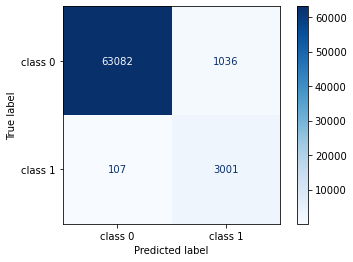

In [35]:
#performance results
print(classification_report(y_test, y_pred1, target_names=target_names))
plot_confusion_matrix(model1, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

  ## Over-sampling with SMOTE

In [36]:
# load library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit on the trainning dataset
X_smote , y_smote = smote.fit_resample(df_X_train_stand, y_train)

print('Original dataset shape:', Counter(y_train))
print('Resample dataset shape:', Counter(y_smote))

Original dataset shape: Counter({0: 256824, 1: 12079})
Resample dataset shape: Counter({0: 256824, 1: 256824})


 ### b) Logistic Regression with Synthetic minority over-sampling technique (LR+SMOTE)

In [37]:
#Run grid search only on training set using cross-validation
start=perf_counter()
parameters={'C':np.logspace(-3,3,7), 'penalty':["l1","l2"]}# l1 lasso l2 ridge
model2=RandomizedSearchCV(LogisticRegression(solver='saga' ,max_iter=1000),parameters,cv=5, n_jobs=-1, verbose=3)
model2.fit(X_smote,y_smote)
tl=(perf_counter()-start)/3600
print ('Elapsed time: %.2f hrs.' %tl)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Elapsed time: 0.40 hrs.


In [38]:
print("tuned hpyerparameters :(best parameters) ",model2.best_params_)
print("accuracy :",model2.best_score_)
print('Best Model:',model2.best_estimator_)

tuned hpyerparameters :(best parameters)  {'penalty': 'l2', 'C': 100.0}
accuracy : 0.9904623402446997
Best Model: LogisticRegression(C=100.0, max_iter=1000, solver='saga')


In [39]:
y_pred2=model2.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99     64118
     class 1       0.76      0.97      0.86      3108

    accuracy                           0.98     67226
   macro avg       0.88      0.98      0.92     67226
weighted avg       0.99      0.98      0.99     67226



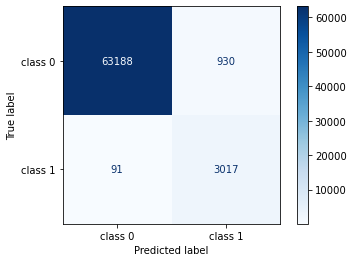

In [40]:
#performance results
print(classification_report(y_test, y_pred2, target_names=target_names))
plot_confusion_matrix(model2, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues); 

### c) Weighted Decision Tree (W-DT)

In [41]:
#Run grid search only on training set using cross-validation, n_jobs to -1, it will use all cores
start=perf_counter()
parameters = {'criterion':['gini','entropy'], 'max_depth' : np.arange(1, 20)}
model3 = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), parameters, cv=5, n_jobs=-1, verbose=3)
# fit on the trainning dataset
model3.fit(df_X_train_stand, y_train)
tl=(perf_counter()-start)/3600
print ('Elapsed time: %.2f hrs.' %tl)

Fitting 5 folds for each of 38 candidates, totalling 190 fits
Elapsed time: 0.01 hrs.


In [42]:
print("tuned hpyerparameters :(best parameters) ",model3.best_params_)
print("accuracy :",model3.best_score_)
print('Best Model:',model3.best_estimator_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 18}
accuracy : 0.9998809981742893
Best Model: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18)


In [43]:
y_pred3 = model3.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     64118
     class 1       0.97      0.98      0.97      3108

    accuracy                           1.00     67226
   macro avg       0.98      0.99      0.99     67226
weighted avg       1.00      1.00      1.00     67226



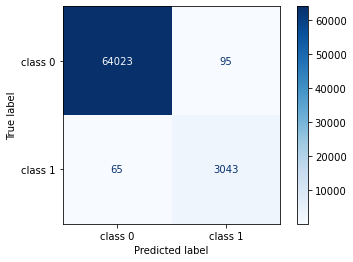

In [44]:
#performance results
print(classification_report(y_test, y_pred3, target_names=target_names))
plot_confusion_matrix(model3, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

## Undersampling using OSS
OneSidedSelection (OSS) is an undersampling technique that combines Tomek Links and the Condensed Nearest Neighbor (CNN) Rule. 

In [45]:
# Import library
from imblearn.under_sampling import OneSidedSelection

In [46]:
# define the undersampling method
oss = OneSidedSelection(random_state=0, n_jobs=-1)
start=perf_counter()
# fit on the trainning dataset
X_oss, y_oss = oss.fit_resample(df_X_train_stand, y_train)
tl=(perf_counter()-start)/3600
print ('Elapsed time: %.2f hrs.' %tl)
# summarize the new class distribution
print('Original dataset shape:', Counter(y_train))
print('Resample dataset shape:', Counter(y_oss))

Elapsed time: 0.12 hrs.
Original dataset shape: Counter({0: 256824, 1: 12079})
Resample dataset shape: Counter({0: 191098, 1: 12079})


### d) Weighted Support Vector Machine with One Sided Selection (SVM+OSS)

In [47]:
#Run grid search only on training set using cross-validation, n_jobs to -1, it will use all cores
start=perf_counter()
parameters = {'C':np.arange(1, 20)}
model4 = GridSearchCV(SVC(class_weight='balanced', kernel='rbf'), parameters, cv=5,n_jobs=-1, verbose=3)
model4.fit(X_oss, y_oss)
tl=(perf_counter()-start)/3600
print ('Elapsed time: %.2f hrs.' %tl)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Elapsed time: 0.19 hrs.


In [48]:
print("tuned hpyerparameters :(best parameters) ",model4.best_params_)
print("accuracy :",model4.best_score_)
print('Best Model:',model4.best_estimator_)

tuned hpyerparameters :(best parameters)  {'C': 19}
accuracy : 0.999596410550771
Best Model: SVC(C=19, class_weight='balanced')


In [49]:
y_pred4 = model4.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     64118
     class 1       0.99      0.99      0.99      3108

    accuracy                           1.00     67226
   macro avg       1.00      1.00      1.00     67226
weighted avg       1.00      1.00      1.00     67226



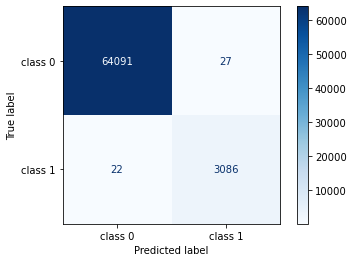

In [50]:
#performance results
print(classification_report(y_test, y_pred4, target_names=target_names))
plot_confusion_matrix(model4, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

### e)  XG Boost, Extreme Gradient Boosting (XGB)

In [51]:
#Run grid search only on training set using cross-validation, n_jobs to -1, it will use all cores
start=perf_counter()
parameters = {'max_depth': np.arange (2, 10),'n_estimators': np.arange(60, 220, 40), 
              'learning_rate': [0.1, 0.01, 0.05],'gamma' : [0.1, 1, 1.5], 
              'subsample' : [0.8, 0.9, 1.0],
             'colsample_bytree' : [0.3, 0.5, 1.0]}
model5 = RandomizedSearchCV(XGBClassifier(eval_metric='logloss',use_label_encoder =False),
                            parameters, cv=5, n_jobs=-1,scoring='roc_auc',verbose=3)
model5.fit(df_X_train_stand, y_train)
tl=(perf_counter()-start)/3600
print ('Elapsed time: %.2f hrs.' %tl)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Elapsed time: 0.03 hrs.


In [52]:
print("tuned hpyerparameters :(best parameters) ",model5.best_params_)
print("roc_auc :",model5.best_score_)
print('Best Model:',model5.best_estimator_)

tuned hpyerparameters :(best parameters)  {'subsample': 0.8, 'n_estimators': 180, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 1.5, 'colsample_bytree': 0.5}
roc_auc : 0.9999998758965015
Best Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=32,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


In [53]:
y_pred5 = model5.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     64118
     class 1       1.00      0.99      1.00      3108

    accuracy                           1.00     67226
   macro avg       1.00      1.00      1.00     67226
weighted avg       1.00      1.00      1.00     67226



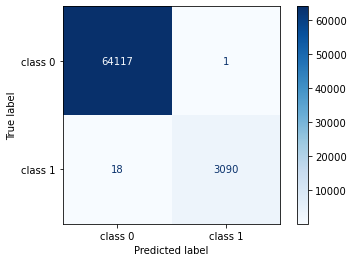

In [54]:
#performance results
print(classification_report(y_test, y_pred5, target_names=target_names))
plot_confusion_matrix(model5, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

In [55]:
#save notebook session
import dill
dill.dump_session('session_esc-07.db')
#to restore a notebook session
#dill.load_session('session_esc-07.db')